## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import skimage

Prague grayscale

In [35]:
data_path = "data/Prague_Grayscale_small/"
dataset_size = 20

imgs = [] ; masks = []
for i in range(1,dataset_size+1):
    imgs.append(skimage.io.imread(data_path + f'tm{i}_1_1.png'))
    masks.append(skimage.io.imread(data_path + f'mask{i}_1.png'))

Prague Colour


In [37]:
data_path = "data/Prague_Colour_small/"
dataset_size = 20

imgs = [] ; masks = []
for i in range(1,dataset_size+1):
    imgs.append(skimage.io.imread(data_path + f'tm{i}_1_1.png'))
    masks.append(skimage.io.imread(data_path + f'mask{i}_1.png'))

In [6]:
print(imgs[0].shape)

(512, 512)


## Arivazhagan & Ganesan, 2003

Utility functions (feature extraction)

In [4]:
def get_features(comat):
    n, k = comat.shape

    c = 0.0
    mx = 0.0
    my = 0.0

    for i in range(n):
        for j in range(k):
            c += (i - j) ** 2 * comat[i, j]
            mx += i * comat[i, j]
            my += j * comat[i, j]

    s = 0.0
    p = 0.0
    for i in range(n):
        for j in range(k):
            v = (i + j - mx - my)
            s += (v ** 3) * comat[i, j]
            p += (v ** 4) * comat[i, j]

    return c, s, p

def log_normalize(x, xmax):
    if xmax == 0:
        return 0.0
    return 255.0 * np.log1p(1 + abs(x)) / np.log1p(1 + abs(xmax))

def normalize(x, xmax):
    if xmax == 0:
        return 0.0
    return 255.0 * x / xmax

def compute_comat(band):
            band = band - band.min()
            band = band / (band.max() + 1e-12)
            band = (band * 15).astype(np.uint8)  # 16 niveaux comme dans la littérature

            C = skimage.feature.graycomatrix(
                band,
                distances=[1],
                angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                levels=16,
                symmetric=True,
                normed=True
            )

            return np.mean(C, axis=(2, 3))


Segmentation algorithm

In [ ]:
seg_imgs = []
for img in imgs:

    w, h = img.shape
    if w % 32 != 0 or h % 32 != 0:
        raise Exception("Image size must be multiple of 32")

    blocks = []
    for i in range(0, w-32):
        for j in range(0, h-32):
            blocks.append(img[i:i+32, j:j+32])

    wavelet = pywt.Wavelet('db4')
    blocks_ft = []

    LL_cmax = LL_smax = LL_pmax = 0.0
    LH_cmax = LH_smax = LH_pmax = 0.0
    HL_cmax = HL_smax = HL_pmax = 0.0
    HH_cmax = HH_smax = HH_pmax = 0.0

    for block in blocks:

        LL, (LH, HL, HH) = pywt.wavedec2(block, wavelet, level=1)

        LL_comat = compute_comat(LL)
        LH_comat = compute_comat(LH)
        HL_comat = compute_comat(HL)
        HH_comat = compute_comat(HH)

        blk_features = {}

        blk_features['LL'] = get_features(LL_comat)
        blk_features['LH'] = get_features(LH_comat)
        blk_features['HL'] = get_features(HL_comat)
        blk_features['HH'] = get_features(HH_comat)

        LL_cmax = max(LL_cmax, blk_features['LL'][0])
        LL_smax = max(LL_smax, blk_features['LL'][1])
        LL_pmax = max(LL_pmax, blk_features['LL'][2])

        LH_cmax = max(LH_cmax, blk_features['LH'][0])
        LH_smax = max(LH_smax, blk_features['LH'][1])
        LH_pmax = max(LH_pmax, blk_features['LH'][2])

        HL_cmax = max(HL_cmax, blk_features['HL'][0])
        HL_smax = max(HL_smax, blk_features['HL'][1])
        HL_pmax = max(HL_pmax, blk_features['HL'][2])

        HH_cmax = max(HH_cmax, blk_features['HH'][0])
        HH_smax = max(HH_smax, blk_features['HH'][1])
        HH_pmax = max(HH_pmax, blk_features['HH'][2])

        blocks_ft.append(blk_features)

    for blk in blocks_ft:

        LLc, LLs, LLp = blk['LL']
        LHc, LHs, LHp = blk['LH']
        HLc, HLs, HLp = blk['HL']
        HHc, HHs, HHp = blk['HH']

        LL_sum = (
            normalize(LLc, LL_cmax) +
            log_normalize(LLs, LL_smax) +
            log_normalize(LLp, LL_pmax)
        )

        LH_sum = (
            normalize(LHc, LH_cmax) +
            log_normalize(LHs, LH_smax) +
            log_normalize(LHp, LH_pmax)
        )

        HL_sum = (
            normalize(HLc, HL_cmax) +
            log_normalize(HLs, HL_smax) +
            log_normalize(HLp, HL_pmax)
        )

        HH_sum = (
            normalize(HHc, HH_cmax) +
            log_normalize(HHs, HH_smax) +
            log_normalize(HHp, HH_pmax)
        )

        blk['SUM'] = LL_sum + LH_sum + HL_sum + HH_sum

    nbx = w - 32
    nby = h - 32
    seg = np.zeros((nbx, nby))

    i = 0; j = 0
    for idx in range(len(blocks) - nby):
        # Horizontal
        seg[i, j] += abs(
            blocks_ft[idx]['SUM'] -
            blocks_ft[idx + 1]['SUM']
        )

        # Vertical
        seg[i, j] += abs(
            blocks_ft[idx]['SUM'] -
            blocks_ft[idx + h - 32]['SUM']
        )

        j += 1
        if j > nby - 1:
            i += 1
            j = 0

    thresh = skimage.filters.threshold_otsu(seg,nbins=16)
    seg_bin = (seg > thresh).astype(np.uint8)

    # seg_img = np.kron(seg_bin, np.ones((480,480)))
    seg_img = np.hstack(seg_bin,np.zeros((480,32)))
    seg_img = np.vstack(seg_bin,np.zeros((32,512)))
    
    seg_img = skimage.morphology.opening(seg_img)
    seg_img = skimage.morphology.skeletonize(seg_img)

    seg_imgs.append(seg_img)


fig, axes = plt.subplots(ncols=3)
idx = np.random.randint(0,20)
axes[0].imshow(seg_imgs[idx], cmap='inferno')
axes[1].imshow(masks[idx])
axes[2].imshow(imgs[idx])

# F1 score
F1 = []
for i in range(len(seg_imgs)):
    TP = np.sum((masks[i] == 1) & (seg_imgs[i] == 1))
    FN = np.sum((masks[i] == 1) & (seg_imgs[i] == 0))
    FP = np.sum((masks[i] == 0) & (seg_imgs[i] == 1))


    F1.append(2*TP / (2*TP + FP + FN))

print(f'Mean accuracy : {np.mean(F1)}')
print(f'Accuracy std : {np.std(F1)}')


TypeError: Cannot interpret '32' as a data type

## Multi Otsu

Mean accuracy : 0.0
Accuracy std : 0.0


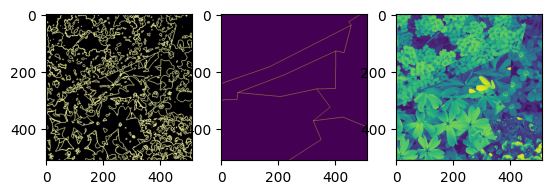

In [ ]:
seg_imgs = []
for img in imgs:
    smth_img = skimage.filters.median(img)
    threshs = skimage.filters.threshold_multiotsu(smth_img)
    seg = np.digitize(img,bins=threshs)
    # mask = np.zeros(seg.shape)
    # for i in range(len(threshs)):
    #     contours = skimage.measure.find_contours(seg,level=i)
    #     for contour in contours:
    #         mask[contour.astype(np.int32)] += 1
    seg = skimage.morphology.closing(seg)
    mask = skimage.segmentation.find_boundaries(seg)
    seg_imgs.append(mask)

fig, axes = plt.subplots(ncols=3)
idx = np.random.randint(0,20)
axes[0].imshow(seg_imgs[idx], cmap='inferno')
axes[1].imshow(masks[idx])
axes[2].imshow(imgs[idx])

# F1 score
F1 = []
for i in range(len(seg_imgs)):
    TP = np.sum((masks[i] == 1) & (seg_imgs[i] == 1))
    FN = np.sum((masks[i] == 1) & (seg_imgs[i] == 0))
    FP = np.sum((masks[i] == 0) & (seg_imgs[i] == 1))


    F1.append(2*TP / (2*TP + FP + FN))

print(f'Mean accuracy : {np.mean(F1)}')
print(f'Accuracy std : {np.std(F1)}')


## SLIC

Mean accuracy : 0.0
Accuracy std : 0.0


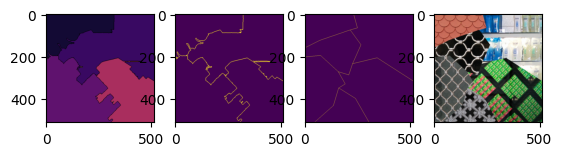

In [ ]:
from skimage.segmentation import slic

seg_imgs = []
seg_masks = []
for img in imgs:

    segments = slic(img,n_segments = 10,compactness = 20)
    # segments = slic(img,n_segments = 10,compactness = 10,channel_axis=None)
    mask = skimage.segmentation.find_boundaries(segments)
    seg = skimage.measure.label(mask,background=1)
    seg_imgs.append(seg)
    seg_masks.append(mask)

# F1 score
F1 = []
for i in range(len(seg_imgs)):
    true_mask = skimage.morphology.dilation(masks[i],skimage.morphology.disk(3))
    pred_mask = skimage.morphology.dilation(seg_imgs[i],skimage.morphology.disk(3))
    TP = np.sum((true_mask == 1) & (pred_mask == 1))
    FN = np.sum((true_mask == 1) & (pred_mask == 0))
    FP = np.sum((true_mask == 0) & (pred_mask == 1))


    F1.append(2*TP / (2*TP + FP + FN))

print(f'Mean F1 : {np.mean(F1)}')
print(f'F1 std : {np.std(F1)}')

fig, axes = plt.subplots(ncols=4)
idx = np.random.randint(0,20)
axes[0].imshow(seg_imgs[idx], cmap='inferno')
axes[1].imshow(seg_masks[idx])
axes[2].imshow(masks[idx])
axes[3].imshow(imgs[idx])